In [93]:
import os

import numpy as np

from scipy import ndimage

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img

import astropy.time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, SqrtStretch

from photutils.centroids import centroid_com as cen

from sunpy.net.helioviewer import HelioviewerClient
import sunpy.map
from sunpy.map import Map
from sunpy.map import MapSequence
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.net import helioviewer
from sunpy.visualization.animator import MapSequenceAnimator

import sunkit_image.coalignment as coal

import imageio

In [2]:
hv = helioviewer.HelioviewerClient()  
for sourceid, obs in hv.data_sources.items():
    print(f"{sourceid}: {obs}")

('SOHO', 'EIT', None, '171'): 0
('SOHO', 'EIT', None, '195'): 1
('SOHO', 'EIT', None, '284'): 2
('SOHO', 'EIT', None, '304'): 3
('SOHO', 'LASCO', 'C2', 'white-light'): 4
('SOHO', 'LASCO', 'C3', 'white-light'): 5
('SOHO', 'MDI', None, 'magnetogram'): 6
('SOHO', 'MDI', None, 'continuum'): 7
('SDO', 'AIA', None, '94'): 8
('SDO', 'AIA', None, '131'): 9
('SDO', 'AIA', None, '171'): 10
('SDO', 'AIA', None, '193'): 11
('SDO', 'AIA', None, '211'): 12
('SDO', 'AIA', None, '304'): 13
('SDO', 'AIA', None, '335'): 14
('SDO', 'AIA', None, '1600'): 15
('SDO', 'AIA', None, '1700'): 16
('SDO', 'AIA', None, '4500'): 17
('SDO', 'HMI', None, 'continuum'): 18
('SDO', 'HMI', None, 'magnetogram'): 19
('STEREO_A', 'SECCHI', 'EUVI', '171'): 20
('STEREO_A', 'SECCHI', 'EUVI', '195'): 21
('STEREO_A', 'SECCHI', 'EUVI', '284'): 22
('STEREO_A', 'SECCHI', 'EUVI', '304'): 23
('STEREO_B', 'SECCHI', 'EUVI', '171'): 24
('STEREO_B', 'SECCHI', 'EUVI', '195'): 25
('STEREO_B', 'SECCHI', 'EUVI', '284'): 26
('STEREO_B', 'SECC

In [3]:
hv = HelioviewerClient()  
file = hv.download_jp2('2012/01/01', observatory="SDO", instrument="AIA", measurement="4500")  

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

<sunpy.map.sources.sdo.AIAMap object at 0x7faf3282b8e0>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 4500.0 Angstrom
Wavelength:		 4500.0 Angstrom
Observation Date:	 2012-01-01 00:00:08
Exposure Time:		 0.500957 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599707 0.599707] arcsec / pix
Reference Pixel:	 [2050.8899 2047.    ] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[  0,   2,   0, ...,   0,   0,   0],
       [252,   0,   2, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
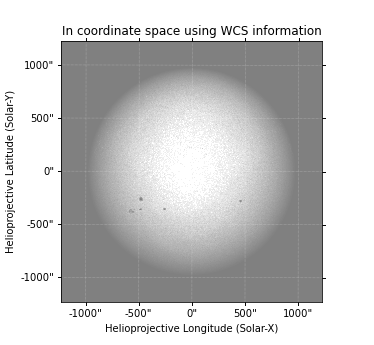
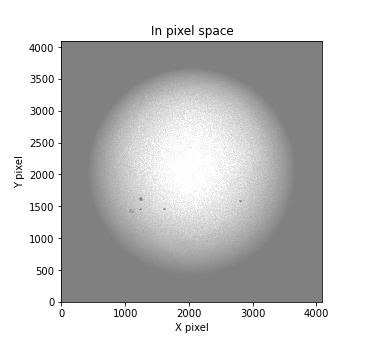
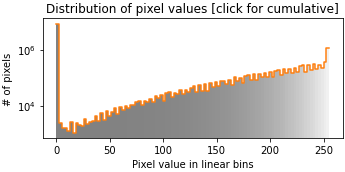
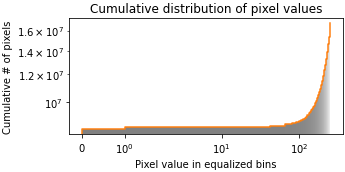

In [58]:
aia = Map(file)  
aia

In [5]:
# aia_map = sunpy.map.Map(file)
# aia_map.plot()
# aia_map.draw_limb()

# # let's add contours as well
# aia_map.draw_contours([10,20,30,40,50,60,70,80,90] * u.percent)

# plt.colorbar()
# plt.show()

In [6]:
file

'/Users/waritwij/sunpy/data/2012_01_01__00_00_08_40__SDO_AIA_AIA_4500.jp2'

In [117]:
a = aia.data
print(a)

[[  0   2   0 ...   0   0   0]
 [252   0   2 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [84]:
com = ndimage.measurements.center_of_mass(a)
com

(2074.2758760443776, 2048.938685857621)

In [85]:
com2 = cen(a)
com2

array([2048.93868586, 2074.27587604])

In [86]:
refpix = aia.reference_pixel
refpix

PixelPair(x=<Quantity 2050.8899 pix>, y=<Quantity 2047. pix>)

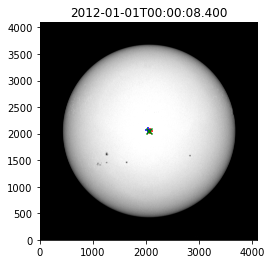

In [87]:
plt.imshow(a, origin = 'lower', cmap = 'gray', vmin = 0, vmax = 255)
plt.scatter(com[0], com[1], color = 'r', marker = '+')
plt.scatter(com2[0], com2[1], color = 'b', marker = '+')
plt.scatter(refpix[0], refpix[1], color = 'g', marker = 'x')
plt.title(aia.date)
plt.show()

In [202]:
def plotCentroid(sun_map, show_plot = True, save_fig = False):
    """
    Plots the image of a file and marks the 'center of flux' in the image.
    
    file: jp2 image
        The image fetched by HelioviewerClient.
        
    Returns: the 'center of flux' coordinate.
    """
    map_array = sun_map.data
    com = cen(map_array)
    ref = sun_map.reference_pixel
    delta = (com[0] - ref.x.value, com[1] - ref.y.value)
    
    plt.figure(figsize = (10, 10))
    plt.imshow(map_array, origin = 'lower', cmap = 'gray', vmin = 0, vmax = 255)
    plt.scatter(com[0], com[1], s = 400, color = 'r', marker = '+')
    plt.scatter(ref[0], ref[1], s = 400, color = 'b', marker = '+')
    plt.title(sun_map.date)
    
    file_name = '/Users/waritwij/Documents/GitHub/astro_jitter/maps/' + sun_map.date.value[:10] + '.png'
    
    if save_fig:
        plt.savefig(file_name, format = 'png')
 
    if show_plot:
        plt.show()
    else:
        print('plotted')
    
    return file_name, delta

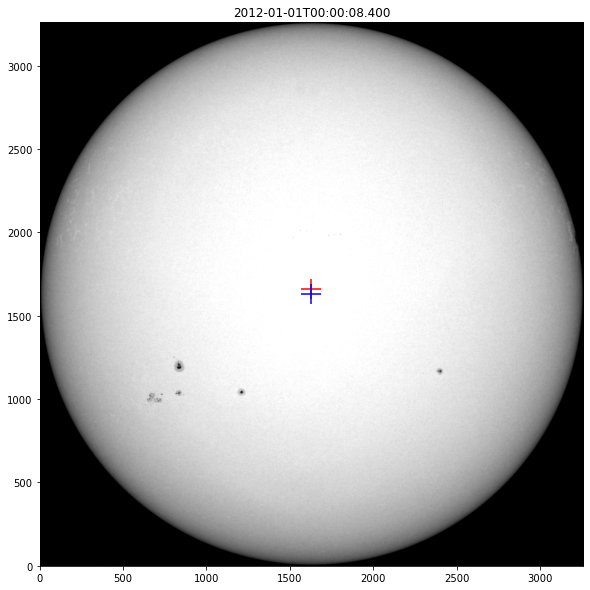

('/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-01.png',
 (-1.9646347468788008, 27.286128365274408))

In [203]:
plotCentroid(aia_submap)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/var/folders/jy/sjsyz6954zv918vnjmc0xzfr0000gn/T/ipykernel_22226/528535032.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10, 10))
/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/waritwij/opt/anaconda3/envs/astro_jitter_env/lib/python3.8/site-packages/astropy/time/formats.py:1372: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


plotted


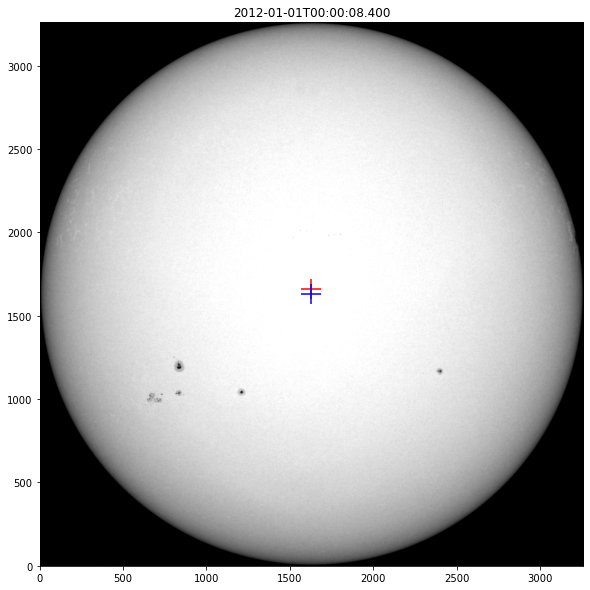

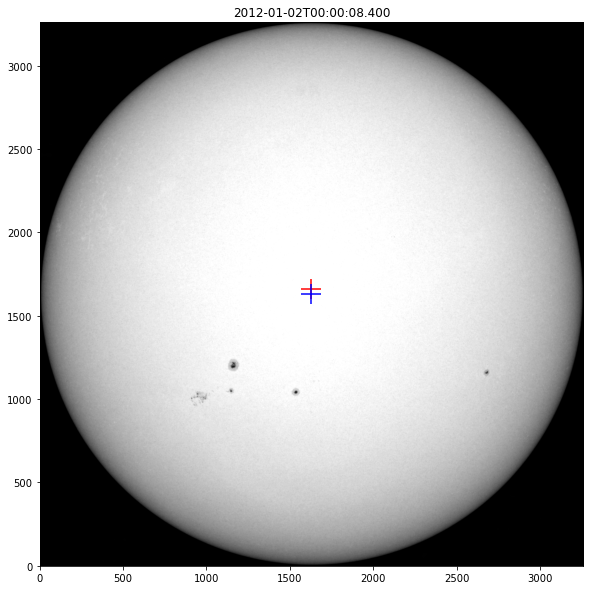

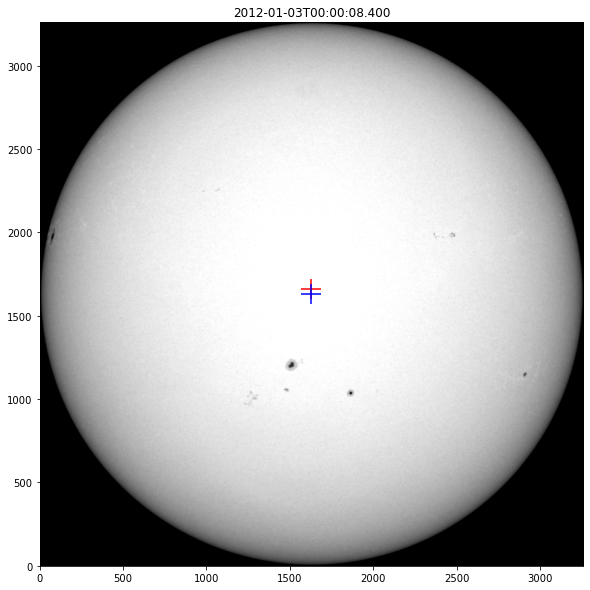

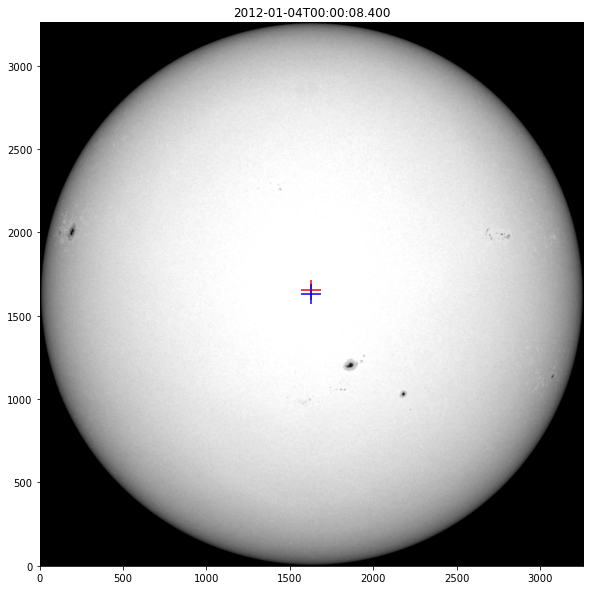

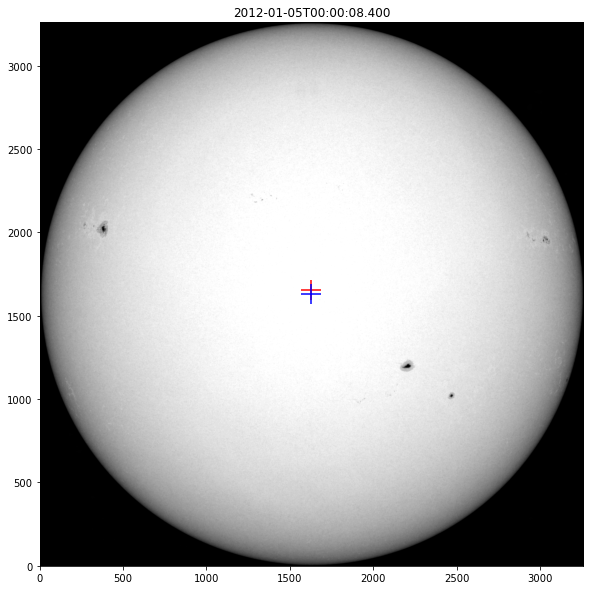

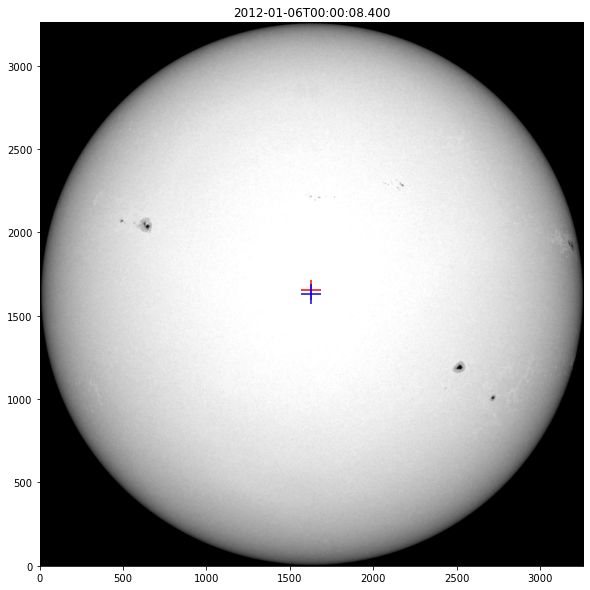

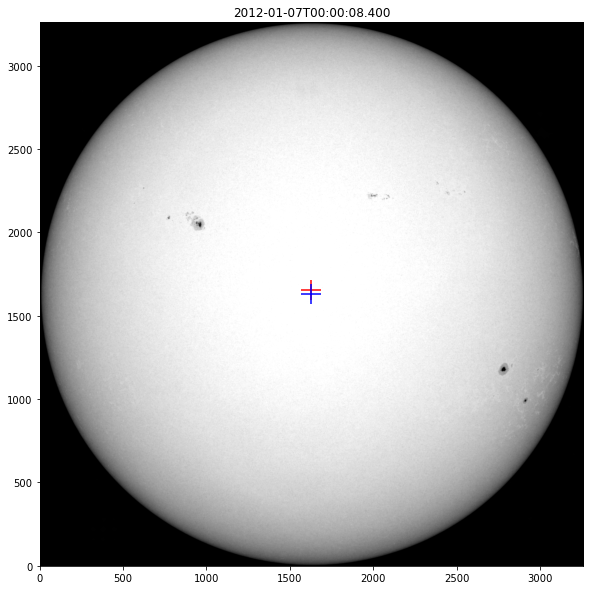

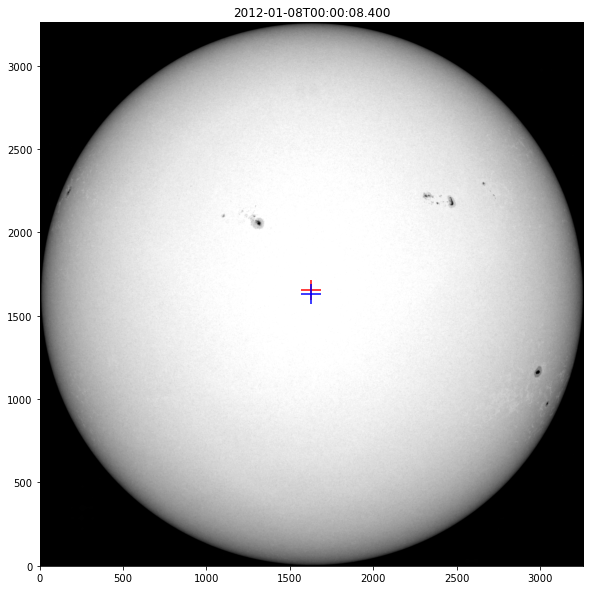

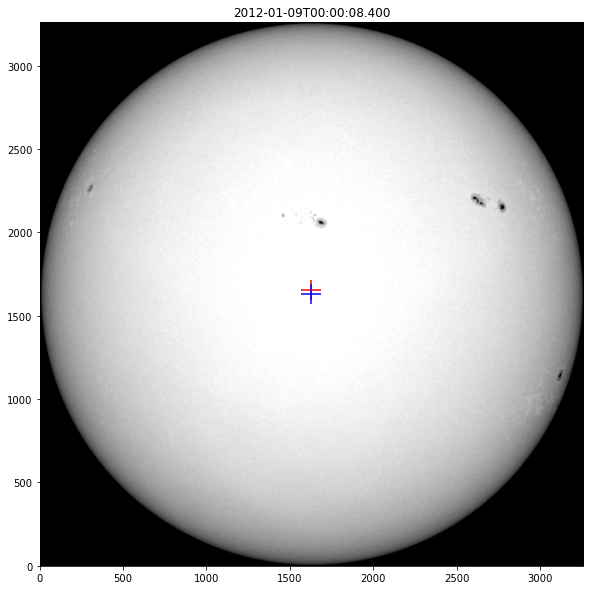

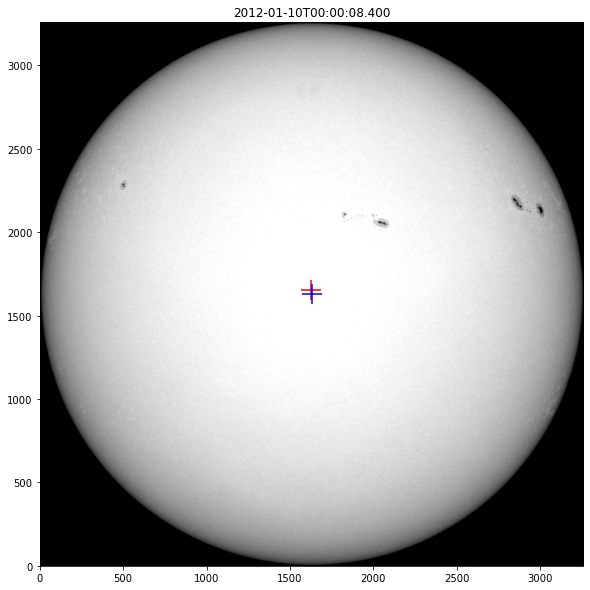

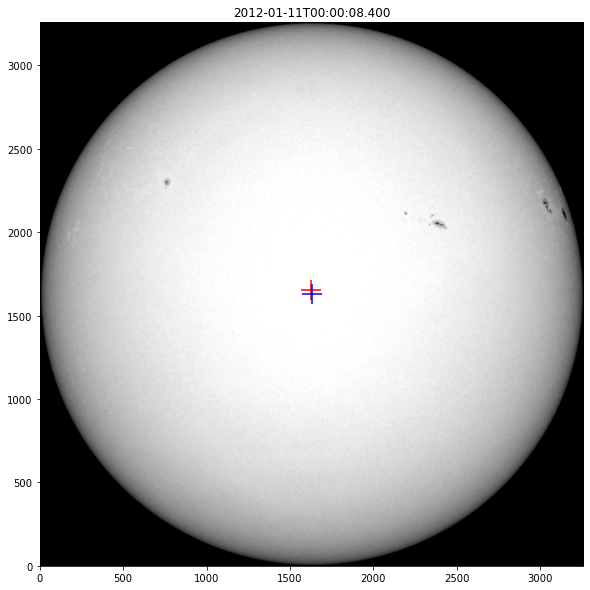

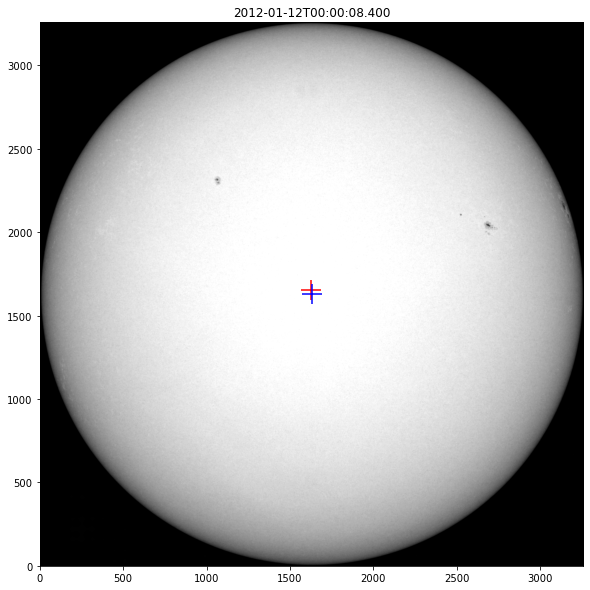

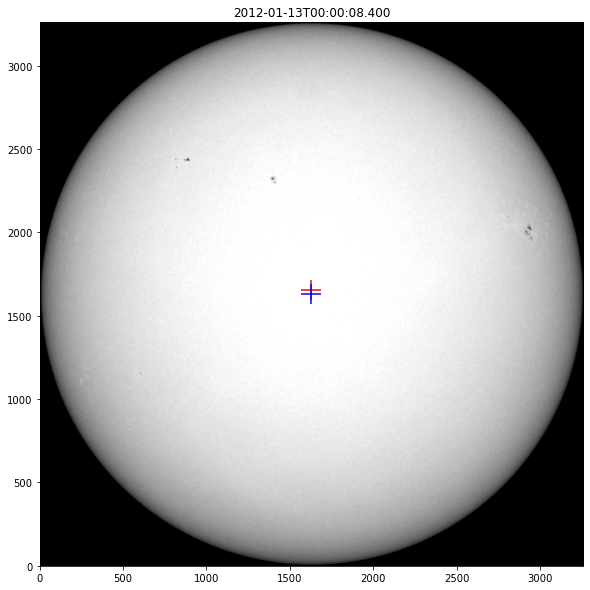

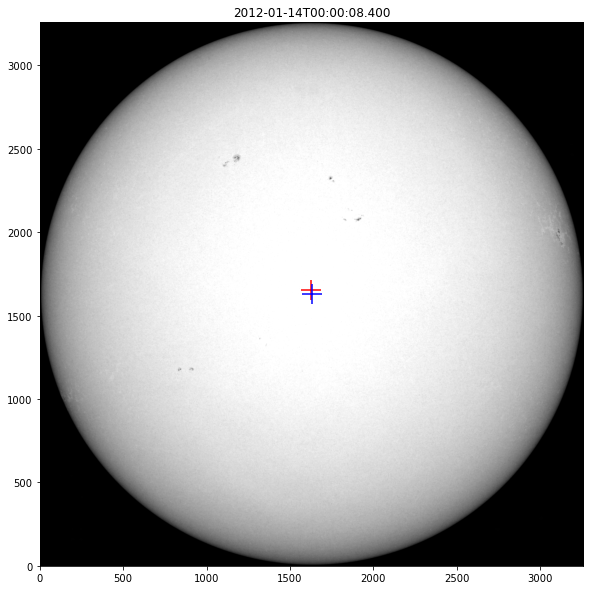

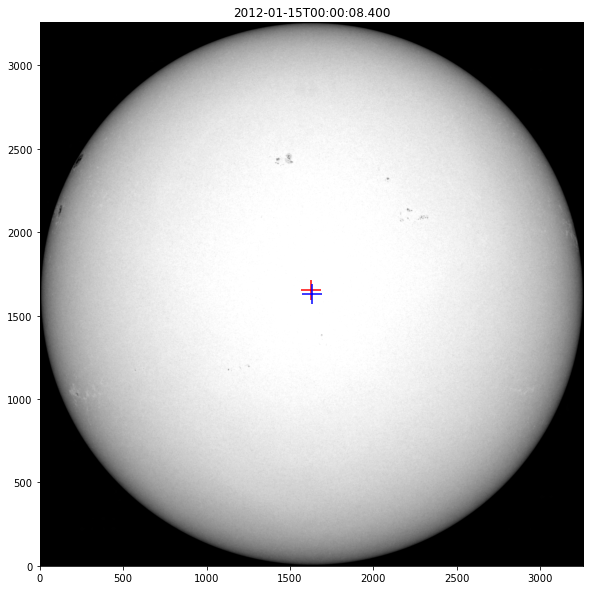

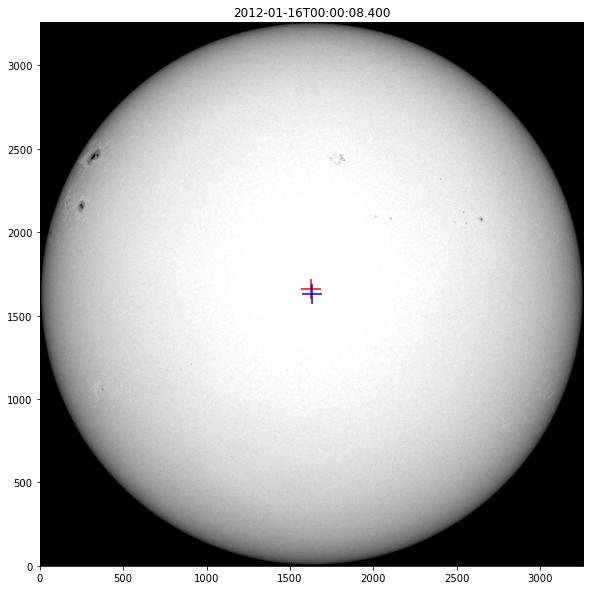

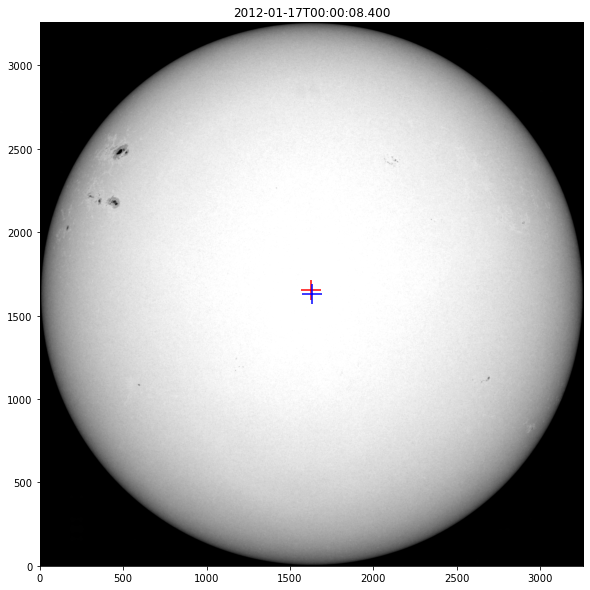

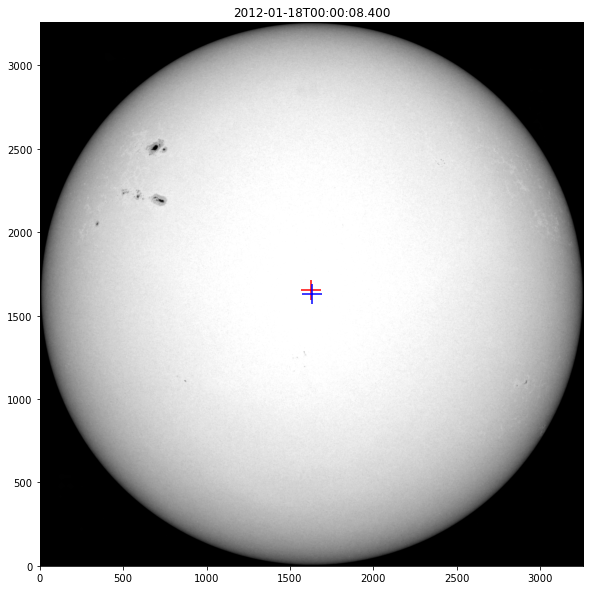

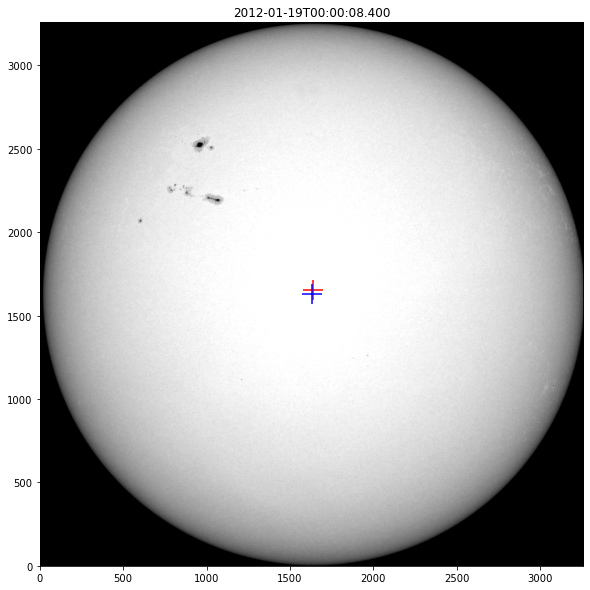

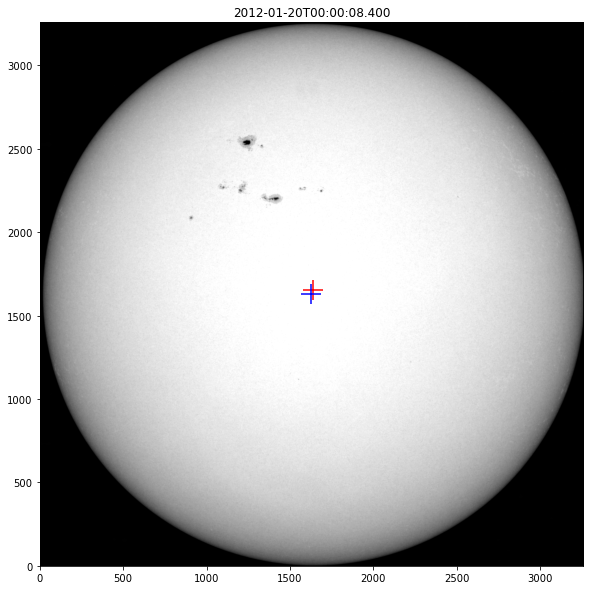

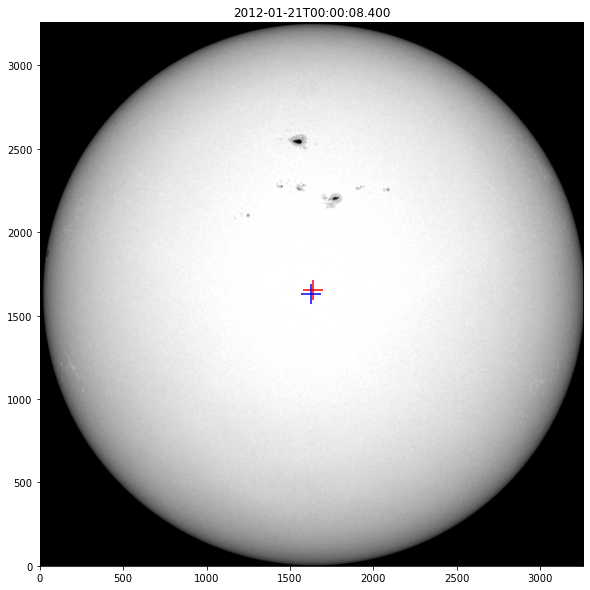

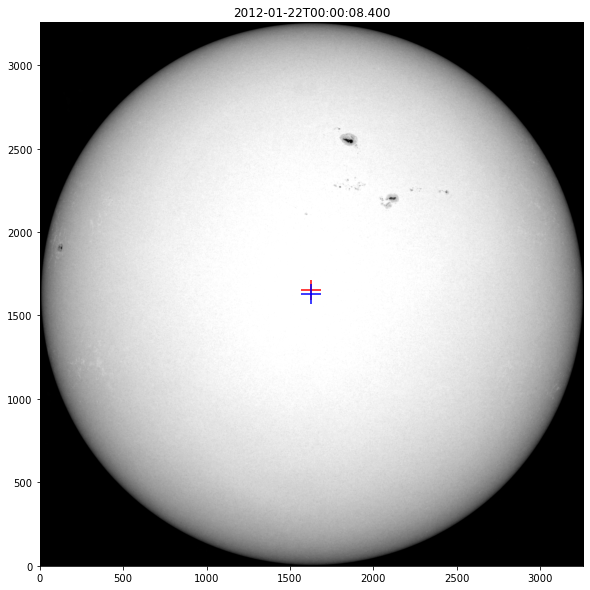

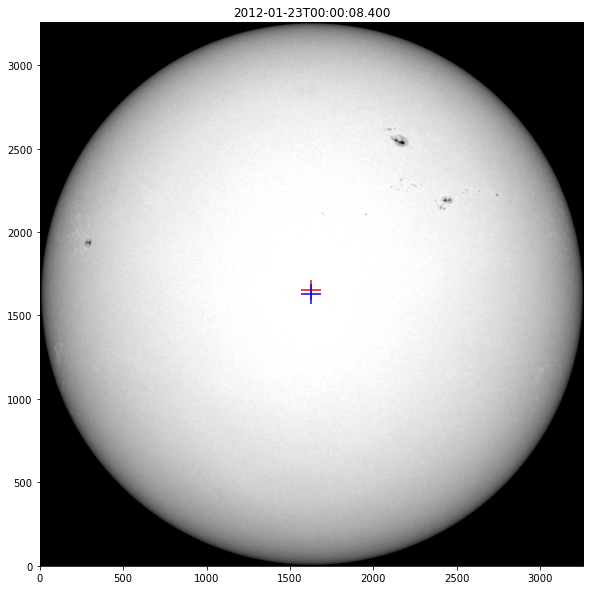

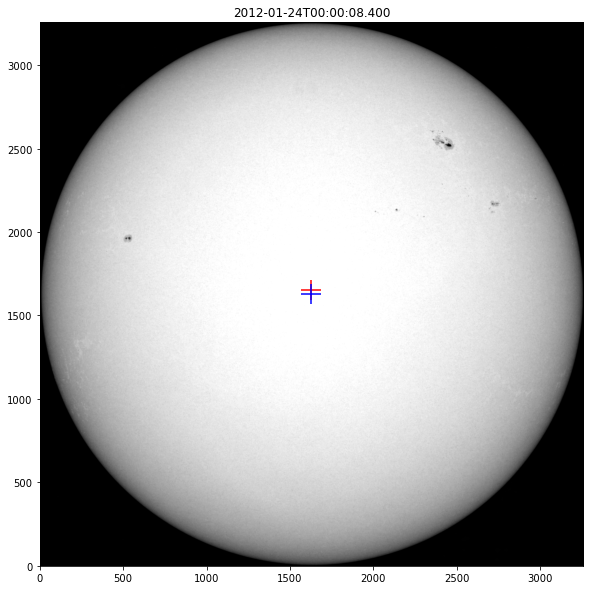

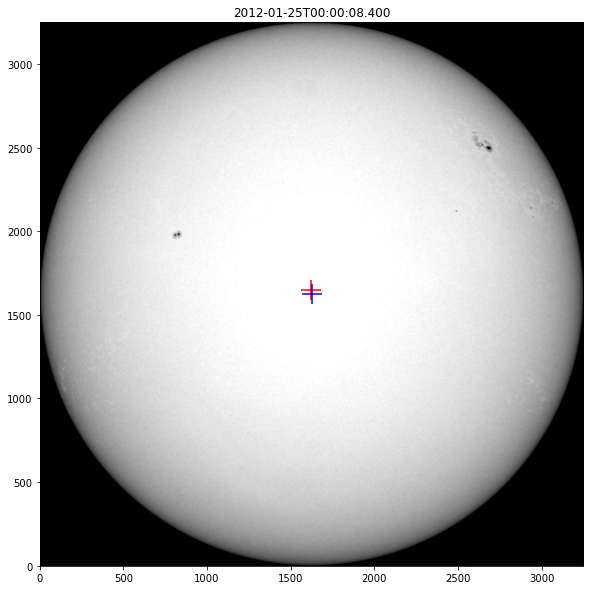

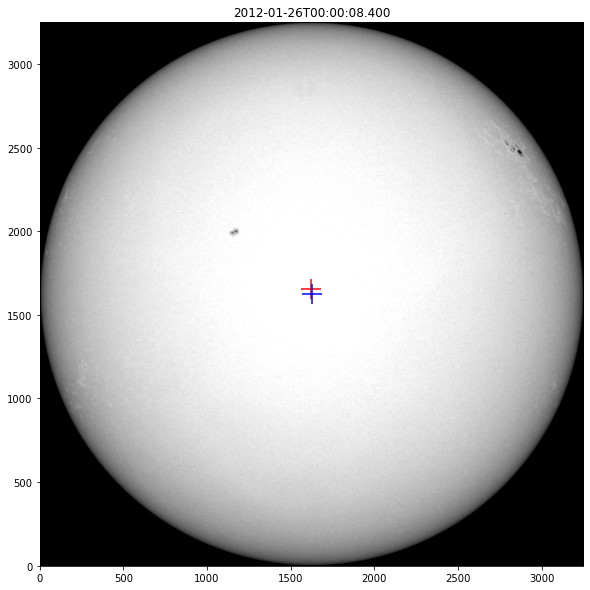

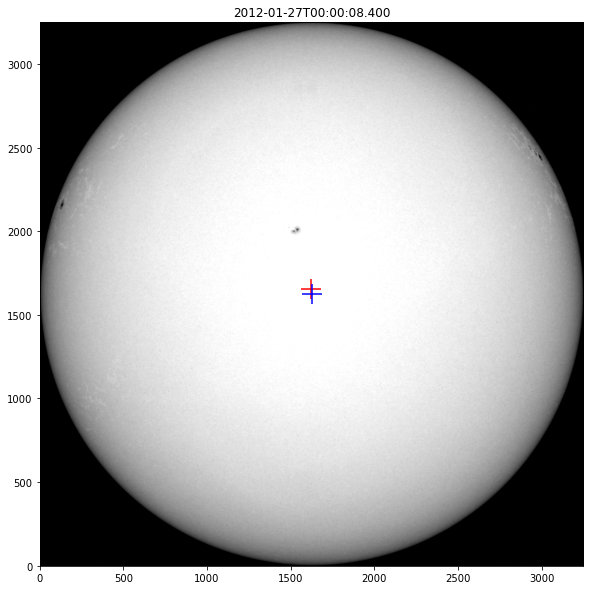

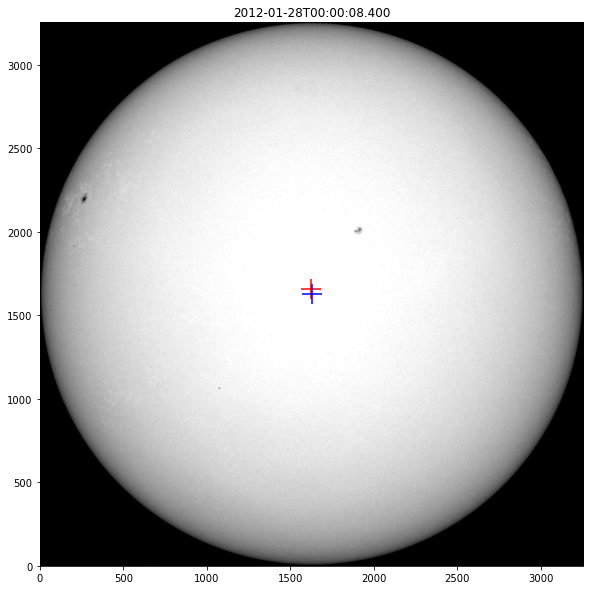

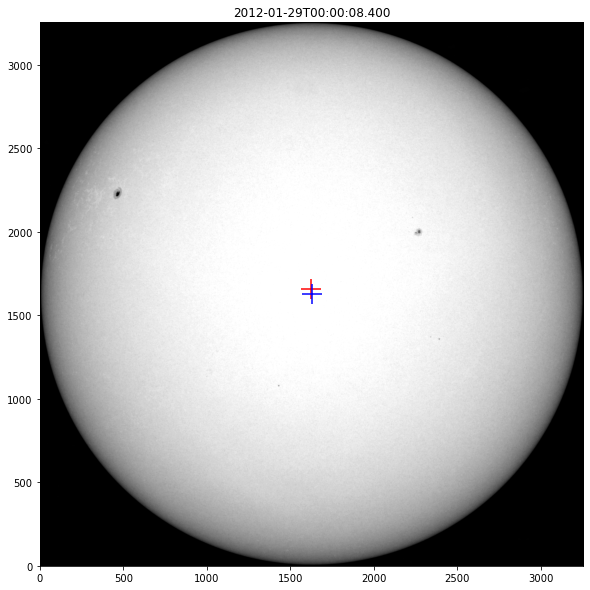

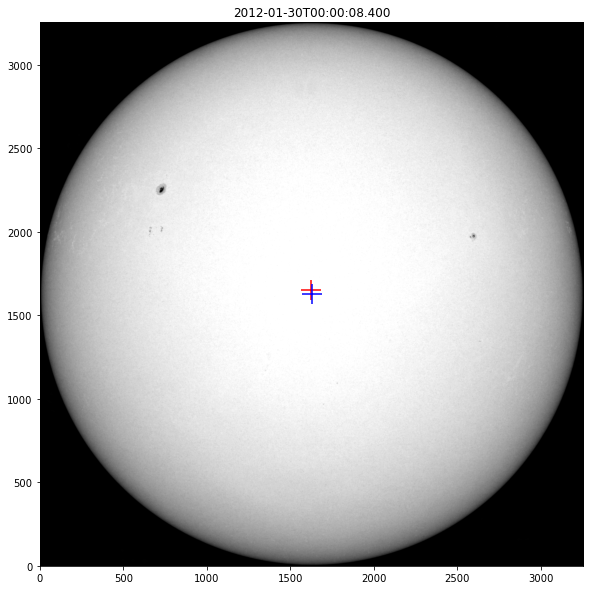

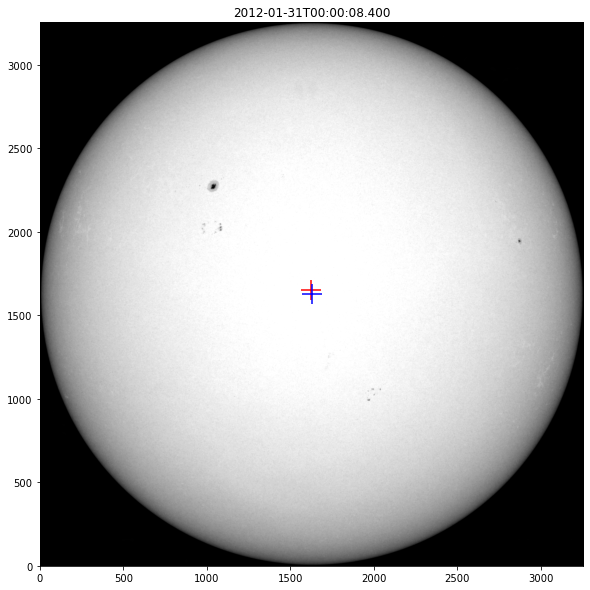

In [204]:
filenames = []
deltas = []
for i in range(1, 32):
    if i < 10:
        date = f'0{i}'
    else:
        date = f'{i}'
    file = hv.download_jp2('2012/01/' + date, observatory="SDO", instrument="AIA", measurement="4500")
    sun_map = Map(file)
    bound = sunpy.map.on_disk_bounding_coordinates(sun_map)
    sun_map_bound = sun_map.submap(bound[0], top_right = bound[1])
    result = plotCentroid(sun_map_bound, show_plot = False, save_fig = True)
    filenames.append(result[0])
    deltas.append(result[1])

In [205]:
filenames

['/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-01.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-02.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-03.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-04.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-05.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-06.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-07.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-08.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-09.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-10.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-11.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-12.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-13.png',
 '/Users/waritwij/Documents/GitHub/astro_jitter/maps/2012-01-14.png',
 '/Users/waritwij/Do

In [206]:
deltas

[(-1.9646347468788008, 27.286128365274408),
 (-2.03779470941231, 27.46304956596896),
 (-2.0237410073550564, 27.263552874970173),
 (-1.6845177195684755, 26.47685156620014),
 (-0.8248503839729437, 25.871898751289336),
 (-0.5310761493449263, 25.872545891966183),
 (-0.6579752961511076, 25.78509605899353),
 (-0.7462346752201938, 25.573256754593103),
 (-0.9575257829280872, 25.59085285606716),
 (-1.185909801870821, 25.620655777622687),
 (-1.3442007854453095, 25.986719951104988),
 (-1.1728863865375843, 26.01951341341578),
 (-1.7272882311649482, 26.605842028346387),
 (-1.6406524803487628, 26.66584355080886),
 (-1.845086736061603, 26.569030942692734),
 (-1.8129148412151608, 26.67300717114881),
 (-1.5671120992333272, 26.438371456817777),
 (-0.9004273314235434, 26.630653703183043),
 (9.47767765904041, 23.06636860648632),
 (9.86724455353442, 22.477430523402973),
 (10.442112093765672, 22.024659644756184),
 (-0.7550915600133976, 25.529608583352),
 (-0.6866402313428352, 25.599060167147627),
 (-0.37747

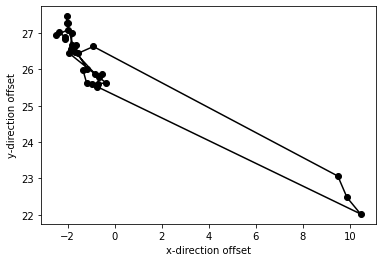

In [267]:
x = np.array([])
y = np.array([])

for delta in deltas:
    x = np.append(x, delta[0])
    y = np.append(y, delta[1])

dist = np.sqrt(np.square(x) + np.square(y))

plt.plot(x, y, '-ok')
plt.xlabel('x-direction offset')
plt.ylabel('y-direction offset')
plt.show()

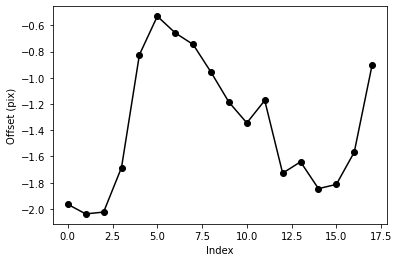

In [250]:
plt.plot(x, '-ok')
plt.xlabel('Index')
plt.ylabel('Offset (pix)')
plt.show()

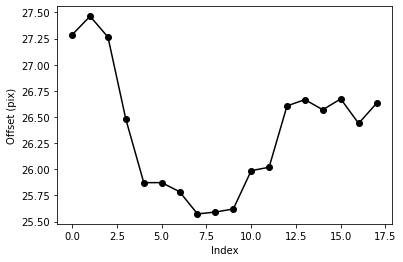

In [251]:
plt.plot(y, '-ok')
plt.xlabel('Index')
plt.ylabel('Offset (pix)')
plt.show()

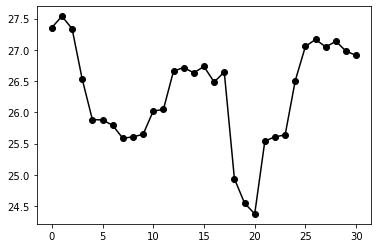

In [268]:
plt.plot(dist, '-ok')

In [211]:
# Build GIF
with imageio.get_writer(filenames[0][-14:-4] + ' to ' + filenames[-1][-14:-4] + '.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [118]:
a 

array([[  0,   2,   0, ...,   0,   0,   0],
       [252,   0,   2, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [109]:
file2 = hv.download_jp2('2012/01/19', observatory="SDO", instrument="AIA", measurement="4500")
aia2 = Map(file2)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

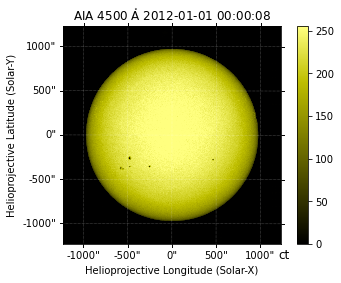

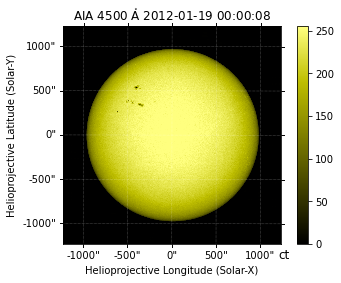

In [110]:
aia.peek()
aia2.peek()

In [111]:
print(aia.data)
aia2.data.size

[[  0   2   0 ...   0   0   0]
 [252   0   2 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


16777216

In [112]:
a2 = coal.clip_edges(aia2.data, np.full(4096, 1)*u.pix, np.full(4096, 1)*u.pix)
com2 = ndimage.measurements.center_of_mass(a2)
com2

(2069.004080517839, 2058.954474796214)

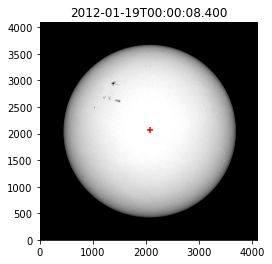

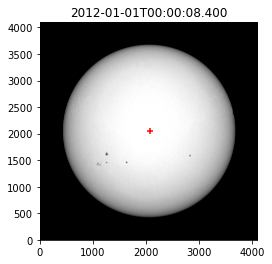

In [119]:
plt.imshow(a2, origin = 'lower', cmap = 'gray', vmin = 0, vmax = 255)
plt.scatter(com2[0], com2[1], color = 'r', marker = '+')
plt.title(aia2.date)
plt.show()

plt.imshow(a, origin = 'lower', cmap = 'gray', vmin = 0, vmax = 255)
plt.scatter(com[0], com[1], color = 'r', marker = '+')
plt.title(aia.date)
plt.show()

In [120]:
print(a2.shape)
print(a.shape)

(4094, 4094)
(4096, 4096)


In [22]:
# shift = coal.calculate_shift(a, a2)

In [23]:
# coal.apply_shifts(aia2, shift[0], shift[1])

In [113]:
mapseq = MapSequence([aia, aia2])

<sunpy.map.mapsequence.MapSequence object at 0x7faf32743220>
MapSequence of 2 elements, with maps from AIAMap
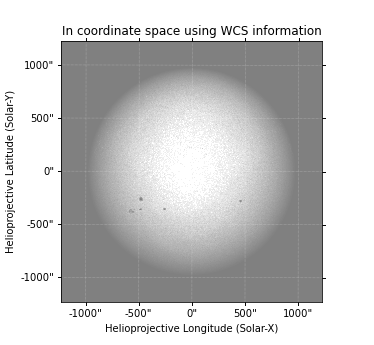
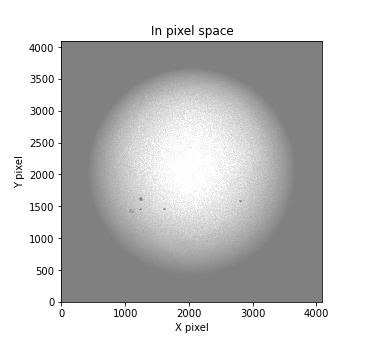
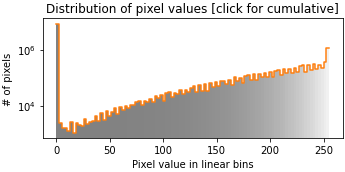
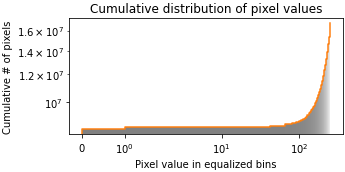
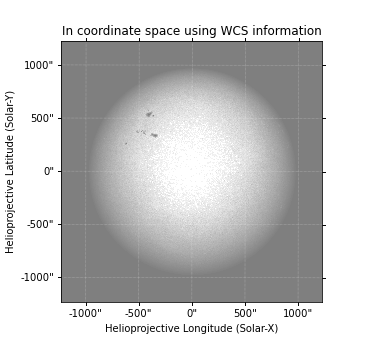
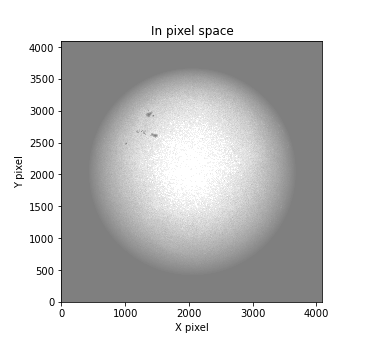
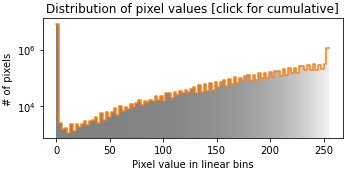
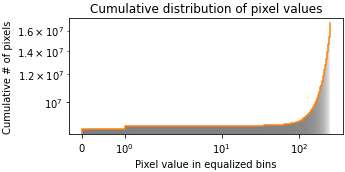

In [114]:
mapseq

In [37]:
mapseq_aligned = coal.mapsequence_coalign_by_match_template(mapseq)

<sunpy.map.mapsequence.MapSequence object at 0x7faf3224ba30>
MapSequence of 2 elements, with maps from AIAMap
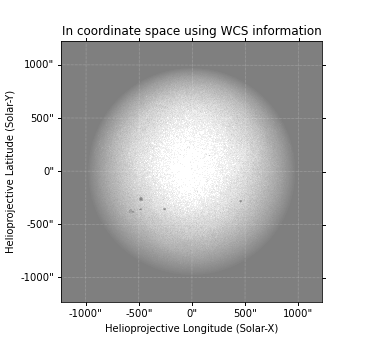
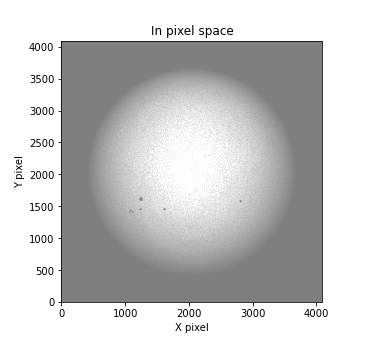
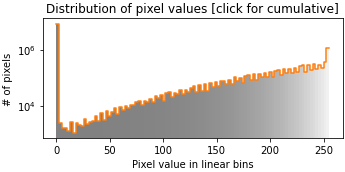
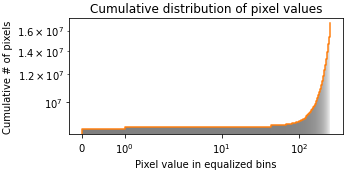
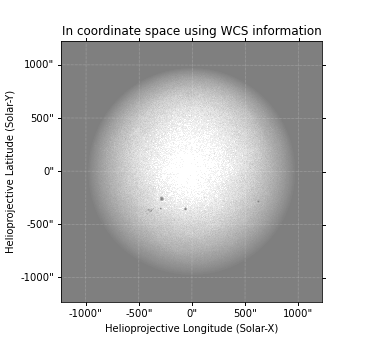
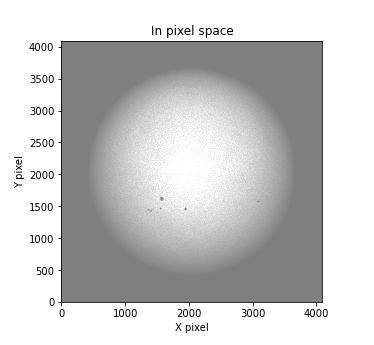
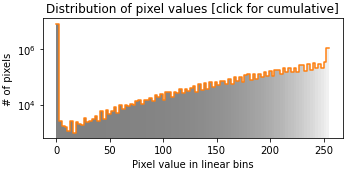
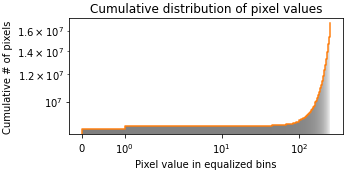

In [38]:
mapseq_aligned

In [72]:
pic0 = mapseq_aligned[0].data
pic0

array([[252,   0,   2, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [73]:
pic1 = mapseq_aligned[1].data
pic1

array([[248,   0,   2, ...,   0,   0,   0],
       [ 12,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

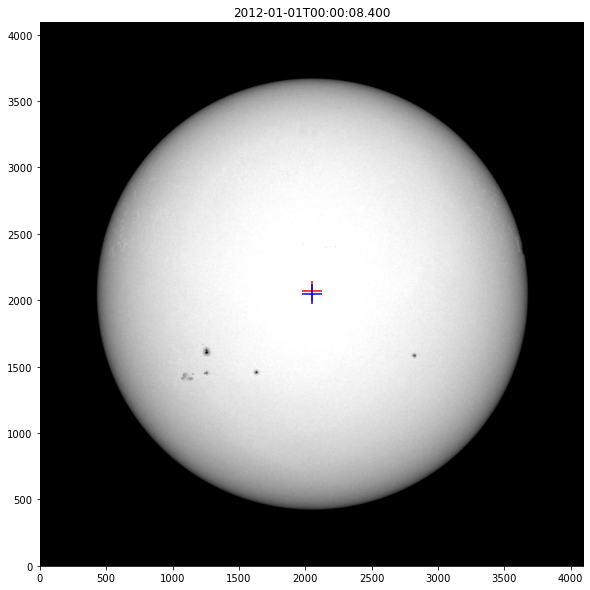

[2048.93857679 2073.2759202 ]
PixelPair(x=<Quantity 2050.8899 pix>, y=<Quantity 2047. pix>)


In [80]:
centerr = cen(pic0)
ref = mapseq_aligned[0].reference_pixel

plt.figure(figsize = (10, 10))
plt.imshow(pic0, origin = 'lower', cmap = 'gray', vmin = 0, vmax = 255)
plt.scatter(centerr[0], centerr[1], s = 400, color = 'r', marker = '+')
plt.scatter(ref[0], ref[1], s = 400, color = 'b', marker = '+')
plt.title(mapseq_aligned[0].date)
file_name = '/Users/waritwij/Documents/GitHub/astro_jitter/' + mapseq_aligned[0].date.value[:10] + '_aligned.png'
plt.savefig(file_name, format = 'png')
plt.show()

print(centerr)
print(ref)

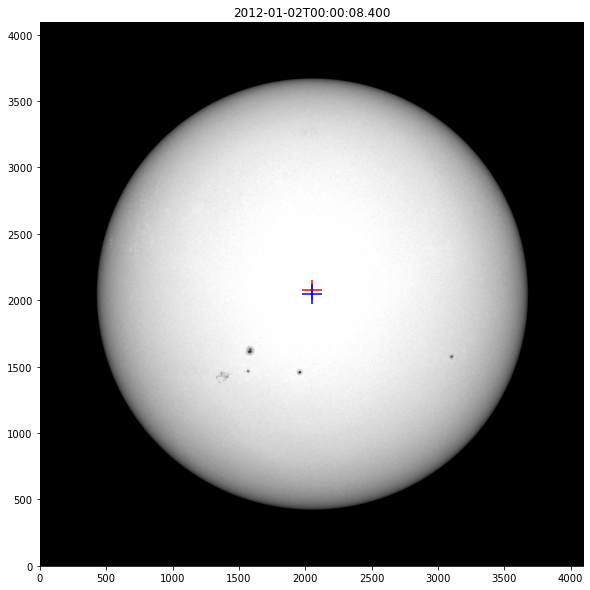

[2048.87289514 2073.43266175]
PixelPair(x=<Quantity 2050.88623308 pix>, y=<Quantity 2047.05022713 pix>)


In [81]:
centerr1 = cen(pic1)
reff = mapseq_aligned[1].reference_pixel

plt.figure(figsize = (10, 10))
plt.imshow(pic1, origin = 'lower', cmap = 'gray', vmin = 0, vmax = 255)
plt.scatter(centerr1[0], centerr1[1], s = 400, color = 'r', marker = '+')
plt.scatter(reff[0], reff[1], s = 400, color = 'b', marker = '+')
plt.title(mapseq_aligned[1].date)
file_name = '/Users/waritwij/Documents/GitHub/astro_jitter/' + mapseq[1].date.value[:10] + '_aligned.png'
plt.savefig(file_name, format = 'png')
plt.show()
print(centerr1)
print(reff)

<sunpy.map.sources.sdo.AIAMap object at 0x7faf3282b8e0>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 4500.0 Angstrom
Wavelength:		 4500.0 Angstrom
Observation Date:	 2012-01-01 00:00:08
Exposure Time:		 0.500957 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599707 0.599707] arcsec / pix
Reference Pixel:	 [2050.8899 2047.    ] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[  0,   2,   0, ...,   0,   0,   0],
       [252,   0,   2, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
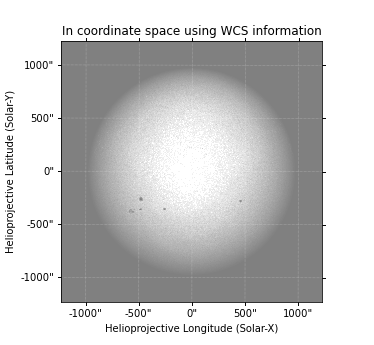
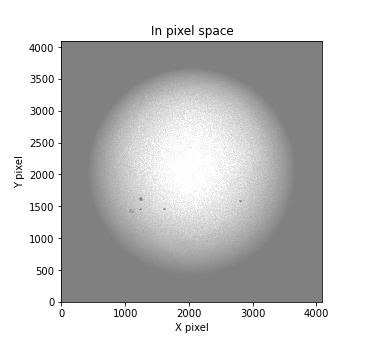
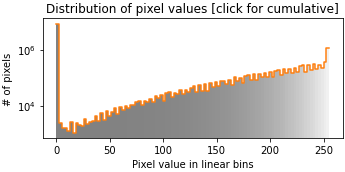
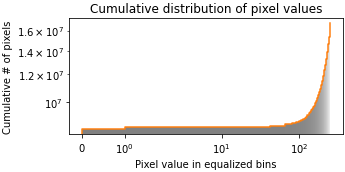

In [62]:
aia

In [68]:
aia.reference_pixel

PixelPair(x=<Quantity 2050.8899 pix>, y=<Quantity 2047. pix>)

In [96]:
bound = sunpy.map.on_disk_bounding_coordinates(aia)

<SkyCoord (Helioprojective: obstime=2012-01-01T00:00:08.400, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-01-01T00:00:08.400, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01599248, -2.9458659, 1.47095448e+11)>): (Tx, Ty) in arcsec
    (-975.6924288, -975.7540387)>

In [104]:
print(bound[0])
print(bound[1])

<SkyCoord (Helioprojective: obstime=2012-01-01T00:00:08.400, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-01-01T00:00:08.400, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01599248, -2.9458659, 1.47095448e+11)>): (Tx, Ty) in arcsec
    (-975.6924288, -975.7540387)>
<SkyCoord (Helioprojective: obstime=2012-01-01T00:00:08.400, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-01-01T00:00:08.400, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01599248, -2.9458659, 1.47095448e+11)>): (Tx, Ty) in arcsec
    (975.81374781, 975.75427499)>


In [105]:
aia_submap = aia.submap(bound[0], top_right = bound[1])

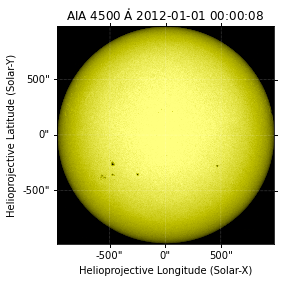

In [106]:
aia_submap.plot()

<sunpy.map.sources.sdo.AIAMap object at 0x7fadd0034940>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 4500.0 Angstrom
Wavelength:		 4500.0 Angstrom
Observation Date:	 2012-01-01 00:00:08
Exposure Time:		 0.500957 s
Dimension:		 [3261. 3261.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599707 0.599707] arcsec / pix
Reference Pixel:	 [1629.8899 1630.    ] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
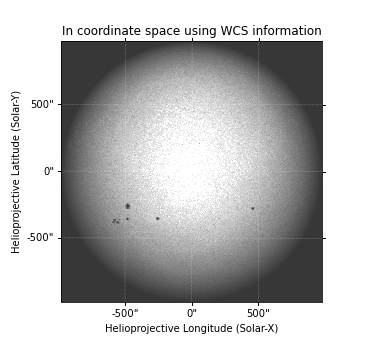
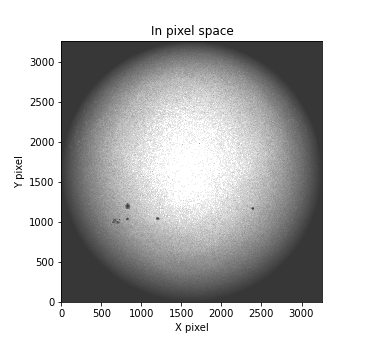
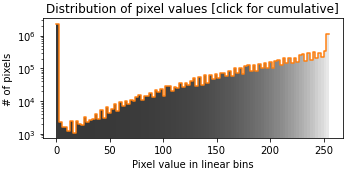
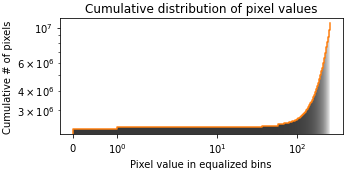

In [108]:
aia_submap

<sunpy.map.sources.sdo.AIAMap object at 0x7faef0376e50>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 4500.0 Angstrom
Wavelength:		 4500.0 Angstrom
Observation Date:	 2012-01-19 00:00:08
Exposure Time:		 0.500321 s
Dimension:		 [3260. 3259.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599707 0.599707] arcsec / pix
Reference Pixel:	 [1629.46 1628.95] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
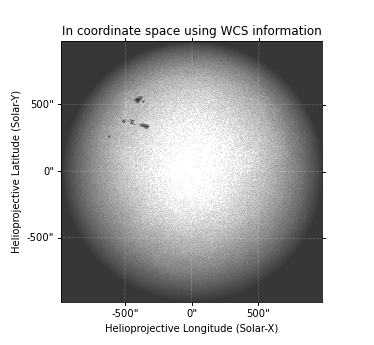
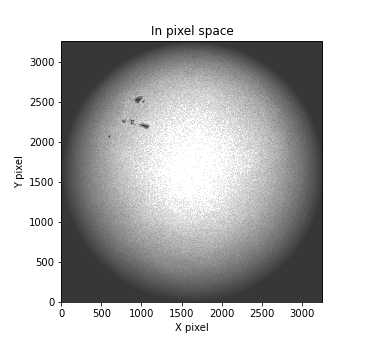
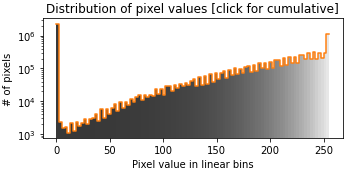
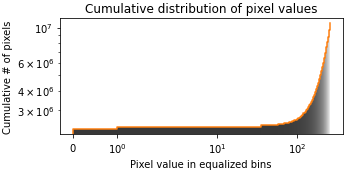

In [121]:
bound2 = sunpy.map.on_disk_bounding_coordinates(aia2)
aia2_submap =  aia2.submap(bound2[0], top_right = bound2[1])
aia2_submap

In [127]:
arr = np.array([[0, 0, 0, 0, 0],
                [0, 1, 1, 1, 0],
                [0, 2, 3, 2, 0],
                [0, 1, 1, 1, 0],
                [0, 0, 0, 0, 0]])
arr

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 2, 3, 2, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [128]:
cen(arr)

array([2., 2.])

In [134]:
arr2 = np.array([[0, 1, 1, 1, 0],
                 [0, 2, 3, 2, 0],
                 [0, 1, 1, 1, 0],
                 [0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0]])
arr2

array([[0, 1, 1, 1, 0],
       [0, 2, 3, 2, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [135]:
print(cen(arr2))
print(ndimage.measurements.center_of_mass(arr2))

[2. 1.]
(1.0, 2.0)


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

<sunpy.map.sources.sdo.AIAMap object at 0x7faf04114550>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 4500.0 Angstrom
Wavelength:		 4500.0 Angstrom
Observation Date:	 2012-01-01 00:00:08
Exposure Time:		 0.500957 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599707 0.599707] arcsec / pix
Reference Pixel:	 [2050.8899 2047.    ] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[  0,   2,   0, ...,   0,   0,   0],
       [252,   0,   2, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
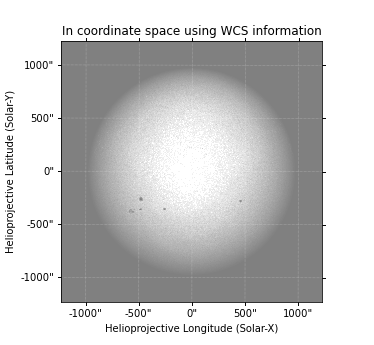
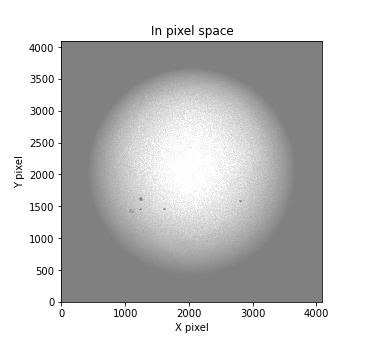
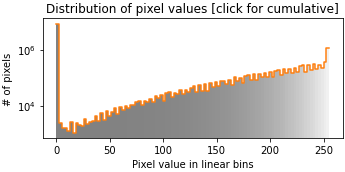
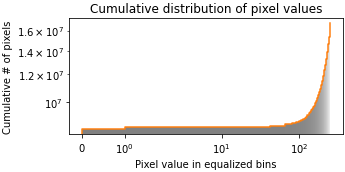

In [188]:
file = hv.download_jp2('2012/01/01', observatory="SDO", instrument="AIA", measurement="4500")
themap = Map(file)
themap

In [189]:
b = sunpy.map.on_disk_bounding_coordinates(themap)
print(b[0])
print(b[1])

<SkyCoord (Helioprojective: obstime=2012-01-01T00:00:08.400, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-01-01T00:00:08.400, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01599248, -2.9458659, 1.47095448e+11)>): (Tx, Ty) in arcsec
    (-975.6924288, -975.7540387)>
<SkyCoord (Helioprojective: obstime=2012-01-01T00:00:08.400, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-01-01T00:00:08.400, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01599248, -2.9458659, 1.47095448e+11)>): (Tx, Ty) in arcsec
    (975.81374781, 975.75427499)>


<sunpy.map.sources.sdo.AIAMap object at 0x7faf0564bf10>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 4500.0 Angstrom
Wavelength:		 4500.0 Angstrom
Observation Date:	 2012-01-01 00:00:08
Exposure Time:		 0.500957 s
Dimension:		 [3261. 3261.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599707 0.599707] arcsec / pix
Reference Pixel:	 [1629.8899 1630.    ] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
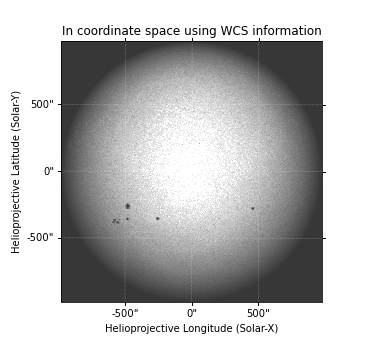
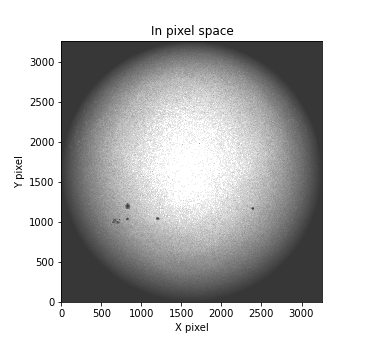
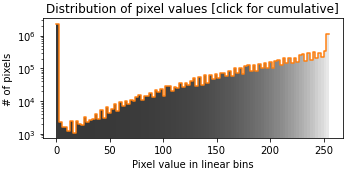
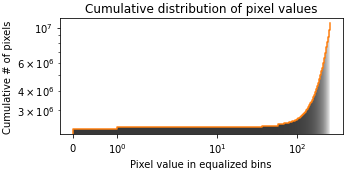

In [190]:
thesubmap = themap.submap(b[0], top_right =  b[1])
thesubmap

In [194]:
cof = cen(thesubmap.data)
print(cof)
reff = thesubmap.reference_pixel
print(reff)

[1627.92526525 1657.28612837]
PixelPair(x=<Quantity 1629.8899 pix>, y=<Quantity 1630. pix>)


In [200]:
reff.x.value

1629.8899000000001

array([1.])